## Image tile computation slow for chunked, compressed source data

See https://github.com/CCI-Tools/cate-core/issues/128

To run this notebook, please install `xarray` 0.9.1, `dask`, `netCDF4`, `matplotlib`.

In [1]:
import xarray as xr
import time
%matplotlib inline

In [2]:
path = "D:\\EOData\\SST\\20000714120000-ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_LT-v02.0-fv01.0.nc"
ds = xr.open_dataset(path)
analysed_sst = ds['analysed_sst']

In [3]:
analysed_sst

<xarray.DataArray 'analysed_sst' (time: 1, lat: 3600, lon: 7200)>
[25920000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2000-07-14T12:00:00
  * lat      (lat) float32 -89.975 -89.925 -89.875 -89.825 -89.775 -89.725 ...
  * lon      (lon) float32 -179.975 -179.925 -179.875 -179.825 -179.775 ...
Attributes:
    units: kelvin
    long_name: analysed sea surface temperature
    valid_min: -300
    valid_max: 4500
    standard_name: sea_water_temperature
    depth: 20 cm
    source: ATSR<1,2>-ESACCI-L3U-v1.0, AATSR-ESACCI-L3U-v1.0, AVHRR<12,14,15,16,17,18>_G-ESACCI-L2P-v1.0, AVHRRMTA-ESACCI-L2P-v1.0
    comment: SST analysis produced for ESA SST CCI project using the OSTIA system in reanalysis mode.

In [4]:
analysed_sst.encoding

{'_FillValue': -32768,
 'add_offset': 273.14999,
 'chunksizes': (1, 663, 1327),
 'complevel': 1,
 'contiguous': False,
 'dtype': dtype('int16'),
 'fletcher32': False,
 'original_shape': (1, 3600, 7200),
 'scale_factor': 0.0099999998,
 'shuffle': True,
 'source': 'D:\\EOData\\SST\\20000714120000-ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_LT-v02.0-fv01.0.nc',
 'zlib': True}

In [5]:
chunksizes = analysed_sst.encoding['chunksizes']

In [6]:
x1 = y1 = 0
x2 = chunksizes[-2]
y2 = chunksizes[-1]

0.023963471113103946 (1327, 663)


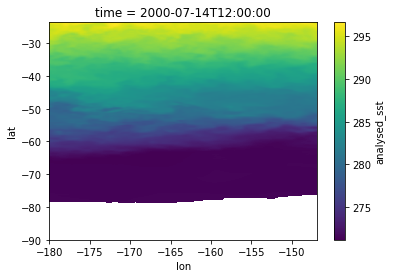

In [7]:
t0 = time.clock()
chunk = analysed_sst[0, y1:y2, x1:x2]
chunk.load()
dt = time.clock() - t0
print(dt, chunk.shape)
chunk.plot()

In [8]:
tile_size = 220
tile_offset = 440
x1 = y1 = tile_offset
x2 = y2 = tile_offset + tile_size

0.0065293988962515925 (220, 220)


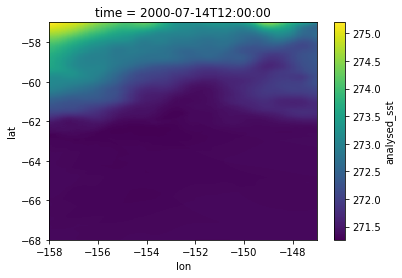

In [9]:
t0 = time.clock()
chunk = analysed_sst[0, x1:x2, x1:x2]
chunk.load()
dt = time.clock() - t0
print(dt, chunk.shape)
chunk.plot()

No using subsampling with step size 4:

In [10]:
tile_zoom = 4
x1 = y1 = tile_offset // tile_zoom
x2 = y2 = tile_offset // tile_zoom + tile_zoom * tile_size
dx = dy = tile_zoom

0.3963036688693018 (220, 220)


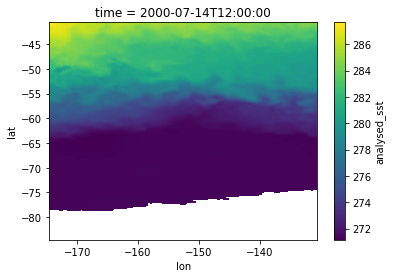

In [11]:
t0 = time.clock()
chunk = analysed_sst[0, y1:y2:dy, x1:x2:dy]
chunk.load()
dt = time.clock() - t0
print(dt, chunk.shape)
chunk.plot()

0.4 seconds, ouch!

Using `DataArray.isel()` doesn't help at all:

0.3958500056630325 (220, 220)


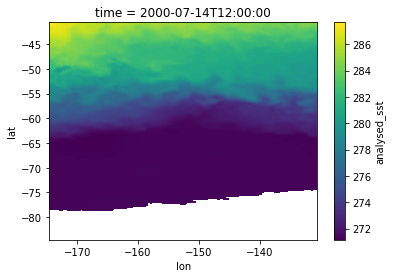

In [12]:
t0 = time.clock()
chunk = analysed_sst.isel(time=0, lat=slice(y1,y2,dy), lon=slice(x1,x2,dy))
chunk.load()
dt = time.clock() - t0
print(dt, chunk.shape)
chunk.plot()

Now trying to do the resampling **after** loading the tile data

0.008874359805815857 (220, 220)


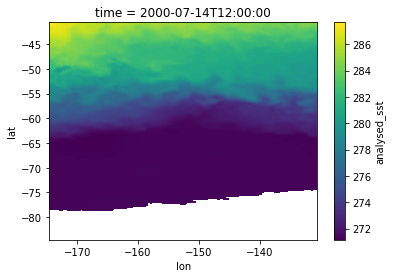

In [14]:
t0 = time.clock()
chunk = analysed_sst[0, y1:y2, x1:x2]
chunk.load()
chunk = chunk[::dy, ::dx]
dt = time.clock() - t0
print(dt, chunk.shape)
chunk.plot()

75 ms --> **success!**

Therefore it seems that the problem originates from `xarray.DataArray` positional indexing with steps sizes.
Should also test without dask installed.